In [1]:
# !pip install networkx
# !pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import networkx as nx

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F



In [3]:
spark = SparkSession.builder.getOrCreate()
spark

21/11/04 15:04:07 WARN Utils: Your hostname, DESKTOP-EUNRE3J resolves to a loopback address: 127.0.1.1; using 172.26.54.87 instead (on interface eth0)
21/11/04 15:04:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/04 15:04:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
!cat data/students/readme.txt

Downloaded From: http://proj.ise.bgu.ac.il/sns

Students� Cooperation Social Network was constructed from the data collected during a �Computer and Network Security� course; a mandatory course at Ben-Gurion University. The social network contains data collected from 185 participating students from two different departments. The course�s social network was created by analyzing the implicit and explicit cooperation among the students while doing their homework assignments. 
The students� cooperation graph contained 185 nodes and 360 links and 3 types of links.
Please Cite:

Predicting Student Exam's Scores by Analyzing Social Network Data , Michael Fire, Gilad Katz, Yuval Elovici, Bracha Shapira, and Lior Rokach, 2012.
Bibtex:
@article{

title={Predicting Student Exam's Scores by Analyzing Social Network Data},
author={Michael Fire, Gilad Katz, Yuval Elovici, Bracha Shapira, and Lior Rokach},
year={2012}
}


In [5]:
edgesDF = pd.read_csv('data/students/multigraph_hashAnonymized.csv',header=0, names=['source', 'target', 'type'])
print(edgesDF.shape)
edgesDF.head()

(360, 3)


,source,target,type
0,1,81,Partners
1,1,81,Time
2,2,27,Time
3,2,136,Time
4,2,129,Partners


In [6]:
name, freq = np.unique(edgesDF[['source', 'target']].values.flatten(), return_counts=True)
nodesDF = pd.DataFrame({'name': name, 'freq': freq})
print(nodesDF.shape)
nodesDF.head()

(185, 2)


,name,freq
0,1,2
1,2,4
2,3,3
3,4,3
4,5,4


In [7]:
G = nx.DiGraph()
G.add_edges_from(edgesDF[['source', 'target']].values.tolist())
print('Number of nodes in DiGraph: {}'.format(G.number_of_nodes()))

Number of nodes in DiGraph: 185


In [8]:
longest_list = nx.dag_longest_path(G)
longest_list

[2, 27, 30, 31, 117, 118, 163, 173]

In [9]:
nx.shortest_path(G, source=longest_list[0], target=longest_list[-1])

[2, 27, 30, 117, 118, 173]

In [10]:
G_filtered = nx.subgraph_view(G, filter_node=lambda x: x in longest_list)
sorted(list(G_filtered.nodes))

[2, 27, 30, 31, 117, 118, 163, 173]

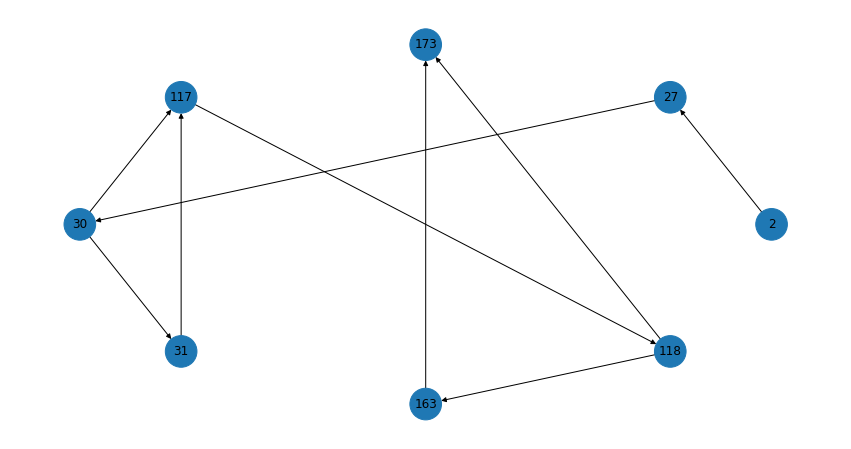

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
node_sizes = [1000]* len(G_filtered.nodes)
nx.draw_circular(G_filtered, with_labels = True, node_size=node_sizes) # 

In [12]:
edges = spark.createDataFrame(edgesDF[['source', 'target']])
edges.show(5)

+------+------+
|source|target|
+------+------+
|     1|    81|
|     1|    81|
|     2|    27|
|     2|   136|
|     2|   129|
+------+------+
only showing top 5 rows



In [13]:
nodes = spark.createDataFrame(nodesDF)
nodes.show(5)

+----+----+
|name|freq|
+----+----+
|   1|   2|
|   2|   4|
|   3|   3|
|   4|   3|
|   5|   4|
+----+----+
only showing top 5 rows



In [14]:
# initial DataFrame
edges_join = edges \
  .withColumnRenamed('source', 'level_0') \
  .withColumnRenamed('target', 'level_1')

i = 1

levels = ['level_0', 'level_1']

while True:
    this_level = 'level_{}'.format(i)
    next_level = 'level_{}'.format(i+1)
    edges_level = edges \
    .withColumnRenamed('source', this_level) \
    .withColumnRenamed('target', next_level)
    edges_join = edges_join.join(edges_level, on=this_level, how='left')
    
    levels.append(next_level)
    
    # Check if DF is empty. Break loop if empty, Otherwise continue with next level
    if edges_join.where(F.col(next_level).isNotNull()).count() == 0:
        break
    else:
        i += 1

# Sort columns and show
edges_fin = (
    edges_join
    .sort('level_0')
    .select(*levels)
    .filter(F.col('level_0') == F.lit(2)) ## source node
    .fillna(-1)
    .withColumn('levels', F.array(*levels[1:]))
    .withColumn('levels', F.array_remove('levels', -1))
    .select('level_0', 'levels')
    .filter(F.array_contains('levels', 173)) ## target node
    .withColumn('length', F.size('levels'))
    .filter(F.col('levels').getItem(F.col('length')-F.lit(1)) == F.lit(173)) ## target node
    .orderBy('length')
    ##.limit(1) ## get shortest
)

edges_fin.show(20,100)

/home/jw/miniconda3/envs/pyspark_venv/lib/python3.9/site-packages/pyspark/sql/column.py:322: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-------+--------------------------------+------+
|level_0|                          levels|length|
+-------+--------------------------------+------+
|      2|         [27, 30, 117, 118, 173]|     5|
|      2|     [27, 30, 31, 117, 118, 173]|     6|
|      2|    [27, 30, 117, 118, 163, 173]|     6|
|      2|    [27, 30, 117, 143, 163, 173]|     6|
|      2|     [27, 30, 31, 117, 118, 173]|     6|
|      2|[27, 30, 31, 117, 143, 163, 173]|     7|
|      2|[27, 30, 31, 117, 118, 163, 173]|     7|
|      2|[27, 30, 31, 117, 143, 163, 173]|     7|
|      2|[27, 30, 31, 117, 118, 163, 173]|     7|
+-------+--------------------------------+------+



In [15]:
edges_fin.printSchema()

root
 |-- level_0: long (nullable = true)
 |-- levels: array (nullable = false)
 |    |-- element: long (containsNull = true)
 |-- length: integer (nullable = false)

